In [1]:
import import_ipynb

import os
import random
import itertools
import numpy as np
from tqdm import tqdm
from IPython import display
from threading import Thread
from multiprocessing import Manager, Queue
from typing import Optional, List, Dict, Tuple
from tqdm.contrib.concurrent import process_map
from custom_types import Vertex, Edge, Cost, Solution, Solver, Evaluation, Graph
from generate_sample_graphs import serialize_graphs, deserialize_graphs, draw_graph

importing Jupyter notebook from generate_sample_graphs.ipynb


In [2]:
if __name__ == "__main__":
  sample_graphs_path = "sample_graphs.dat"
  if os.path.exists(sample_graphs_path):
    with open(sample_graphs_path, "r+b") as fp:
      sample_graphs, _ = deserialize_graphs(fp)

  print(f"Got {len(sample_graphs)} sample graphs")

Got 10000 sample graphs


In [3]:
if __name__ == "__main__":
  small_sample_graph = None
  for g in sample_graphs:
    if 5 <= len(g[0]) < 10:
      small_sample_graph = g
      break
  else:
    small_sample_graph = sample_graphs[0]
    print("WARNING: No sample graphs have between 5 and 10 nodes. This might make visualisation harder")

In [4]:
def cost_of_solution(solution: Solution) -> Cost:
  return sum(map(lambda edge: edge[2], solution))

In [5]:
def bfs(graph: Graph, start: Vertex, end: Vertex) -> Optional[List[Vertex]]:
  vertices, edges = graph
  visited: Dict[Vertex, bool] = {}
  for v in vertices:
    visited[v] = False

  queue: List[List[Vertex]] = [[start]]


  while len(queue) > 0:
    path = queue[0]
    current = path[-1]
    queue = queue[1:]

    if current == end:
      return path

    visited[current] = True
    for edge in edges:
      if edge[0] == current and not visited[edge[1]]:
        queue.append(path+[edge[1]])
      elif edge[1] == current and not visited[edge[0]]:
        queue.append(path+[edge[0]])

  return None

In [6]:
# Using breadth-first search
def is_strongly_connected(graph: Graph) -> bool:
  vertices, edges = graph
  visited: Dict[Vertex, bool] = {}
  for v in vertices:
    visited[v] = False
  
  queue: List[Vertex] = [vertices[0]]

  while len(queue) > 0:
    current = queue[0]
    queue = queue[1:]

    visited[current] = True
    for edge in edges:
      if edge[0] == current and not visited[edge[1]]:
        queue.append(edge[1])
      elif edge[1] == current and not visited[edge[0]]:
        queue.append(edge[0])
  
  for was_visited in visited.values():
    if not was_visited:
      return False

  return True

1.2510119670814697


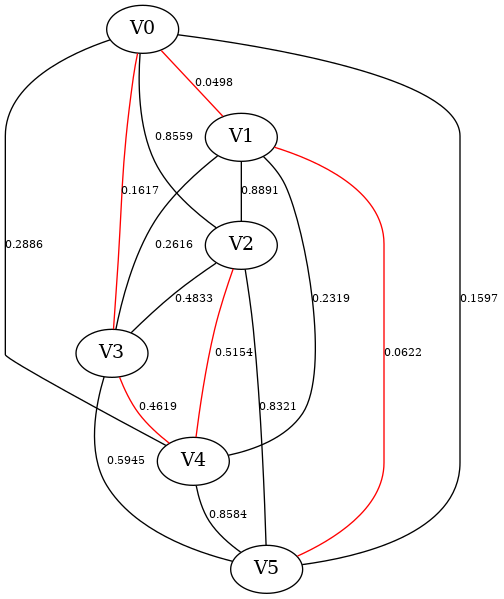

In [7]:
def contains_minor_cycle(graph: Graph) -> bool:
  vertices, edges = graph
  for i, edge in enumerate(edges):
    path = bfs((vertices, edges[:i]+edges[i+1:]), edge[0], edge[1])
    if path is not None and len(path) < len(vertices):
      return True
  return False

greedy: Solver
def greedy(graph: Graph) -> Solution:
  vertices, edges = graph
  solution: List[Edge] = []
  sorted_edges = sorted(edges, key=lambda edge: edge[2])
  num_edges: Dict[Vertex, int] = {}
  for v in vertices:
    num_edges[v] = 0
  
  while not is_strongly_connected((vertices, solution)):
    available_edges = [
      edge for edge in sorted_edges if \
      num_edges[edge[0]] < 2 and \
      num_edges[edge[1]] < 2 and \
      not contains_minor_cycle((vertices, solution+[edge]))
    ]

    assert len(available_edges) > 0

    edge_to_add = available_edges[0]
    num_edges[edge_to_add[0]] += 1
    num_edges[edge_to_add[1]] += 1

    solution.append(edge_to_add)

  return solution

if __name__ == "__main__":
  solution = greedy(small_sample_graph)
  print(cost_of_solution(solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

1.6838643906921498


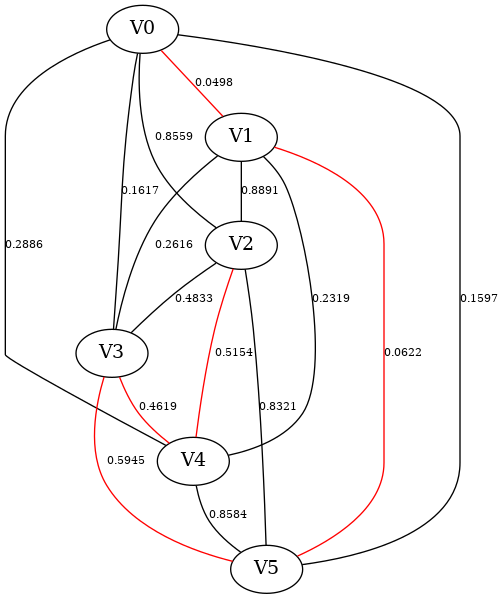

In [8]:
nearest_neighbor: Solver
def nearest_neighbor(graph: Graph) -> Solution:
  vertices, edges = graph
  visited: Dict[Vertex, bool] = {}
  for v in vertices:
    visited[v] = False
  sorted_edges = sorted(edges, key=lambda edge: edge[2])
  solution: List[Edge] = []

  current = vertices[0]
  visited[current] = True

  while not all(list(visited.values())):
    for edge in sorted_edges:
      if edge[0] == current and not visited[edge[1]]:
        solution.append(edge)
        current = edge[1]
        visited[current] = True
        break
      elif edge[1] == current and not visited[edge[0]]:
        solution.append(edge)
        current = edge[0]
        visited[current] = True
        break
    else:
      raise AssertionError("Ran out of edges")
  
  return solution

if __name__ == "__main__":
  solution = nearest_neighbor(small_sample_graph)
  print(cost_of_solution(solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

1.4525053607238774


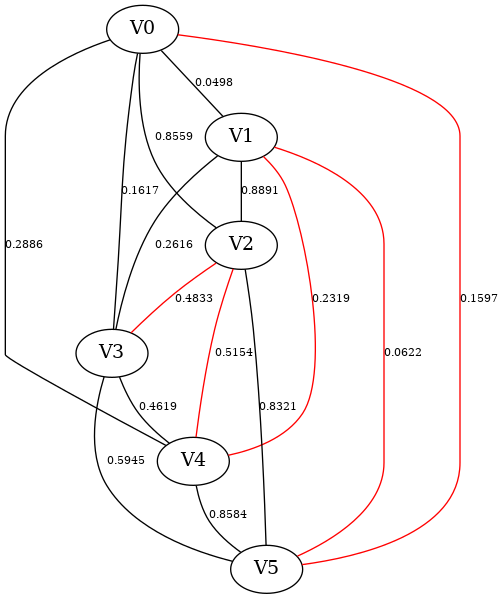

In [9]:
nearest_insertion: Solver
def nearest_insertion(graph: Graph) -> Solution:
  vertices, edges = graph
  in_tour: Dict[Vertex, bool] = {}
  for v in vertices:
    in_tour[v] = False
  
  edge_matrix: Dict[Vertex, Dict[Vertex, float]] = {}
  for v in vertices:
    edge_matrix[v] = {}
  for edge in edges:
    edge_matrix[edge[0]][edge[1]] = edge[2]
    edge_matrix[edge[1]][edge[0]] = edge[2]


  in_tour[edges[0][0]] = True
  in_tour[edges[0][1]] = True

  tour: List[Vertex] = [*edges[0][:2]]

  while len(tour) < len(vertices):  
    min_new_vertex = None
    min_new_vertex_dst = 0
    for v in vertices:
      if in_tour[v]:
        continue
      
      for t in tour:
        dst = edge_matrix[t][v]
        if min_new_vertex is None or dst < min_new_vertex_dst:
          min_new_vertex = v
          min_new_vertex_dst = dst
  
    assert min_new_vertex is not None

    min_new_vertex_cost = 0
    min_new_vertex_idx = -1
    for i, tx in enumerate(tour):
      ty = tour[(i+1)%len(tour)]
      existing_cost = edge_matrix[tx][ty]
      new_cost = edge_matrix[tx][min_new_vertex] + edge_matrix[min_new_vertex][ty]
      additional_cost = new_cost-existing_cost
      if min_new_vertex_idx < 0 or additional_cost < min_new_vertex_cost:
        min_new_vertex_cost = additional_cost
        min_new_vertex_idx = i+1
    
    assert min_new_vertex_idx >= 0

    in_tour[min_new_vertex] = True
    tour = tour[:min_new_vertex_idx] + [min_new_vertex] + tour[min_new_vertex_idx:]

  solution: List[Edge] = []
  for edge in edges:
    i = tour.index(edge[0])
    if tour[(i+1)%len(tour)] == edge[1] or tour[(i-1+len(tour)%len(tour))] == edge[1]:
      solution.append(edge)
  
  max_cost_edge_idx = np.argmax(map(lambda edge: edge[2], solution))

  return solution[:max_cost_edge_idx] + solution[max_cost_edge_idx+1:]

if __name__ == "__main__":
  solution = nearest_insertion(small_sample_graph)
  print(cost_of_solution(solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

1.4525053607238774


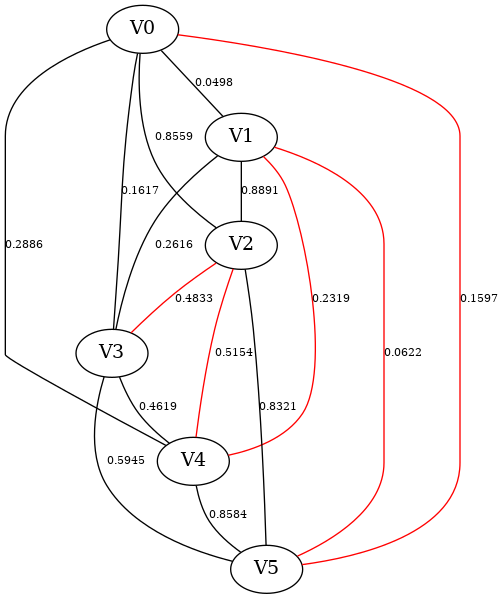

In [10]:
cheapest_insertion: Solver
def cheapest_insertion(graph: Graph) -> Solution:
  vertices, edges = graph
  in_tour: Dict[Vertex, bool] = {}
  for v in vertices:
    in_tour[v] = False
  
  edge_matrix: Dict[Vertex, Dict[Vertex, float]] = {}
  for v in vertices:
    edge_matrix[v] = {}
  for edge in edges:
    edge_matrix[edge[0]][edge[1]] = edge[2]
    edge_matrix[edge[1]][edge[0]] = edge[2]


  in_tour[edges[0][0]] = True
  in_tour[edges[0][1]] = True

  tour: List[Vertex] = [*edges[0][:2]]

  while len(tour) < len(vertices):  
    min_new_vertex = None
    min_new_vertex_cost = 0
    min_new_vertex_idx = 0
    for v in vertices:
      if in_tour[v]:
        continue
      
      for i, tx in enumerate(tour):
        ty = tour[(i+1)%len(tour)]
        existing_cost = edge_matrix[tx][ty]
        new_cost = edge_matrix[tx][v] + edge_matrix[v][ty]
        additional_cost = new_cost-existing_cost
        if min_new_vertex is None or additional_cost < min_new_vertex_cost:
          min_new_vertex = v
          min_new_vertex_cost = additional_cost
          min_new_vertex_idx = i+1
  
    assert min_new_vertex is not None

    in_tour[min_new_vertex] = True
    tour = tour[:min_new_vertex_idx] + [min_new_vertex] + tour[min_new_vertex_idx:]

  solution: List[Edge] = []
  for edge in edges:
    i = tour.index(edge[0])
    if tour[(i+1)%len(tour)] == edge[1] or tour[(i-1+len(tour)%len(tour))] == edge[1]:
      solution.append(edge)
  
  max_cost_edge_idx = np.argmax(map(lambda edge: edge[2], solution))

  return solution[:max_cost_edge_idx] + solution[max_cost_edge_idx+1:]

if __name__ == "__main__":
  solution = cheapest_insertion(small_sample_graph)
  print(cost_of_solution(solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

1.4525053607238774


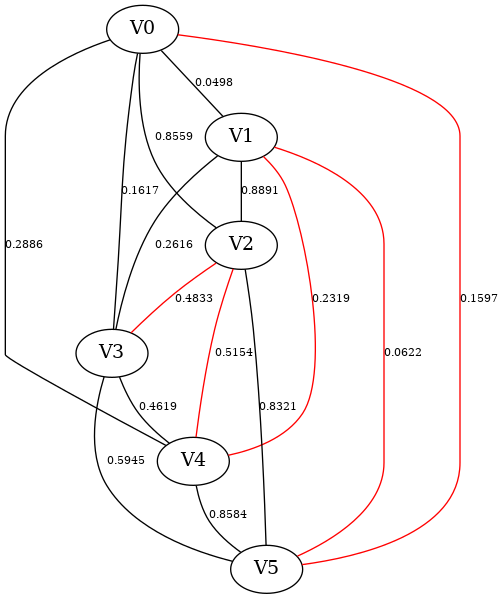

In [11]:
random_insertion: Solver
def random_insertion(graph: Graph) -> Solution:
  vertices, edges = graph
  in_tour: Dict[Vertex, bool] = {}
  for v in vertices:
    in_tour[v] = False
  
  edge_matrix: Dict[Vertex, Dict[Vertex, float]] = {}
  for v in vertices:
    edge_matrix[v] = {}
  for edge in edges:
    edge_matrix[edge[0]][edge[1]] = edge[2]
    edge_matrix[edge[1]][edge[0]] = edge[2]


  in_tour[edges[0][0]] = True
  in_tour[edges[0][1]] = True

  tour: List[Vertex] = [*edges[0][:2]]

  random.seed(int.from_bytes(os.urandom(4), byteorder='little'))

  while len(tour) < len(vertices):
    new_vertex = random.choice([v for v in vertices if not in_tour[v]])
    min_new_vertex_cost = 0
    min_new_vertex_idx = -1
    for i, tx in enumerate(tour):
      ty = tour[(i+1)%len(tour)]
      existing_cost = edge_matrix[tx][ty]
      new_cost = edge_matrix[tx][new_vertex] + edge_matrix[new_vertex][ty]
      additional_cost = new_cost-existing_cost
      if min_new_vertex_idx < 0 or additional_cost < min_new_vertex_cost:
        min_new_vertex_cost = additional_cost
        min_new_vertex_idx = i+1
    
    assert min_new_vertex_idx >= 0

    in_tour[new_vertex] = True
    tour = tour[:min_new_vertex_idx] + [new_vertex] + tour[min_new_vertex_idx:]

  solution: List[Edge] = []
  for edge in edges:
    i = tour.index(edge[0])
    if tour[(i+1)%len(tour)] == edge[1] or tour[(i-1+len(tour)%len(tour))] == edge[1]:
      solution.append(edge)
  
  max_cost_edge_idx = np.argmax(map(lambda edge: edge[2], solution))

  return solution[:max_cost_edge_idx] + solution[max_cost_edge_idx+1:]

if __name__ == "__main__":
  solution = random_insertion(small_sample_graph)
  print(cost_of_solution(solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

1.944057678404445


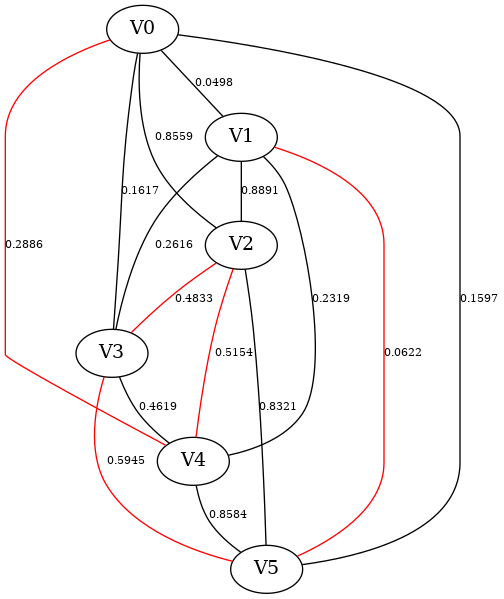

In [12]:
farthest_insertion: Solver
def farthest_insertion(graph: Graph) -> Solution:
  vertices, edges = graph
  in_tour: Dict[Vertex, bool] = {}
  for v in vertices:
    in_tour[v] = False
  
  edge_matrix: Dict[Vertex, Dict[Vertex, float]] = {}
  for v in vertices:
    edge_matrix[v] = {}
  for edge in edges:
    edge_matrix[edge[0]][edge[1]] = edge[2]
    edge_matrix[edge[1]][edge[0]] = edge[2]


  in_tour[edges[0][0]] = True
  in_tour[edges[0][1]] = True

  tour: List[Vertex] = [*edges[0][:2]]

  while len(tour) < len(vertices):  
    max_new_vertex = None
    max_new_vertex_dst = 0
    for v in vertices:
      if in_tour[v]:
        continue
      
      for t in tour:
        dst = edge_matrix[t][v]
        if max_new_vertex is None or dst > max_new_vertex_dst:
          max_new_vertex = v
          max_new_vertex_dst = dst
  
    assert max_new_vertex is not None

    min_new_vertex_cost = 0
    min_new_vertex_idx = -1
    for i, tx in enumerate(tour):
      ty = tour[(i+1)%len(tour)]
      existing_cost = edge_matrix[tx][ty]
      new_cost = edge_matrix[tx][max_new_vertex] + edge_matrix[max_new_vertex][ty]
      additional_cost = new_cost-existing_cost
      if min_new_vertex_idx < 0 or additional_cost < min_new_vertex_cost:
        min_new_vertex_cost = additional_cost
        min_new_vertex_idx = i+1
    
    assert min_new_vertex_idx >= 0

    in_tour[max_new_vertex] = True
    tour = tour[:min_new_vertex_idx] + [max_new_vertex] + tour[min_new_vertex_idx:]

  solution: List[Edge] = []
  for edge in edges:
    i = tour.index(edge[0])
    if tour[(i+1)%len(tour)] == edge[1] or tour[(i-1+len(tour)%len(tour))] == edge[1]:
      solution.append(edge)
  
  max_cost_edge_idx = np.argmax(map(lambda edge: edge[2], solution))

  return solution[:max_cost_edge_idx] + solution[max_cost_edge_idx+1:]

if __name__ == "__main__":
  solution = farthest_insertion(small_sample_graph)
  print(cost_of_solution(solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

In [14]:
if __name__ == "__main__":
  def evaluate(args: "Tuple[Solver, Graph, Queue[Tuple[str, Optional[Evaluation]]]]") -> Evaluation:
    solver, graph, q = args
    solution = solver(graph)
    cost = cost_of_solution(solution)
    evaluation = (solver, graph, solution, cost)
    q.put(("EVALUATION", evaluation))
    return evaluation
      
  def listener(path: str, q: "Queue[Tuple[str, Optional[Evaluation]]]", evaluations: "List[Evaluation]"):
    while True:
      cmd, arg = q.get()
      if cmd == "STOP":
        break
      elif cmd == "EVALUATION":
        evaluations.append(arg)
        _, graph, solution, __ = arg
        with open(path, "wb" if len(evaluations) == 1 else "ab") as fp:
          if len(evaluations) > 1:
            fp.write(b"\n")
          serialize_graphs(fp, graph, (graph[0], solution))
      else:
        raise AssertionError(f"Unknown command: {cmd}")
    
  solvers = [greedy, nearest_insertion, cheapest_insertion, random_insertion, farthest_insertion]
  graphs_to_evaluate = sample_graphs
  to_evaluate: "List[Tuple[Solver, Graph, Queue[Tuple[str, Optional[Evaluation]]]]]" = []
  evaluations: Dict[str, List[Evaluation]] = {}

  evaluations_dir = "evaluations"
  if not os.path.exists(evaluations_dir):
    os.makedirs(evaluations_dir)

  manager = Manager()
  queues: "Dict[str, Queue[Tuple[str, Optional[Evaluation]]]]" = {}

  threads: List[Thread] = []

  for solver in solvers:
    q: "Queue[Tuple[str, Optional[Evaluation]]]" = manager.Queue()
    queues[solver.__name__] = q

    array: List[Evaluation] = []
    evaluations[solver.__name__] = array

    path = os.path.join(evaluations_dir, f"{solver.__name__}.dat")

    if os.path.exists(path):
      with open(path, "r+b") as fp:
        graphs, graph_end_positions = deserialize_graphs(fp)
        for i in range(0, len(graphs)-1, 2):
          graph = graphs[i]
          solution = graphs[i+1][1]
          array.append((solver, graph, solution, cost_of_solution(solution)))

        if len(graph_end_positions) == 0:
          fp.seek(0)
        else:
          fp.seek(graph_end_positions[len(graph_end_positions)//2 * 2 - 1])
        fp.truncate()
    
    already_evaluated_graphs = list(e[1] for e in array)
    still_to_evaluate = list(g for g in graphs_to_evaluate if g not in already_evaluated_graphs)

    print(f"{solver.__name__}: [{len(already_evaluated_graphs)}/{len(graphs_to_evaluate)}] ({100*(len(already_evaluated_graphs)/len(graphs_to_evaluate)):.2f}%) graphs evaluated")
    
    to_evaluate += list(zip(itertools.repeat(solver), still_to_evaluate, itertools.repeat(q)))
    new_thread = Thread(target=listener, args=(path, q, array), daemon=True)
    new_thread.start()
    threads.append(new_thread)

  total_num_to_evaluate = len(solvers)*len(graphs_to_evaluate)
  total_num_evaluated = total_num_to_evaluate - len(to_evaluate)
  print(f"\nTotal: [{total_num_evaluated}/{total_num_to_evaluate}] ({100*(total_num_evaluated/total_num_to_evaluate):.2f}%) graphs evaluated")

  if len(to_evaluate) > 0:
    process_map(evaluate, to_evaluate, max_workers=5, tqdm_class=tqdm, chunksize=1000)


  for q in queues.values():
    q.put(("STOP", None))
  
  for thread in threads:
    thread.join()
  
  if len(to_evaluate) > 0:
    for solver in solvers:
        already_evaluated_graphs = list(e[1] for e in evaluations[solver.__name__])
        print(f"{solver.__name__}: [{len(already_evaluated_graphs)}/{len(graphs_to_evaluate)}] ({100*(len(already_evaluated_graphs)/len(graphs_to_evaluate)):.2f}%) graphs evaluated")

greedy: [10000/10000] (100.00%) graphs evaluated
nearest_insertion: [8869/10000] (88.69%) graphs evaluated
cheapest_insertion: [2214/10000] (22.14%) graphs evaluated
random_insertion: [992/10000] (9.92%) graphs evaluated
farthest_insertion: [293/10000] (2.93%) graphs evaluated

Total: [22368/50000] (44.74%) graphs evaluated


100%|██████████| 27632/27632 [00:06<00:00, 4248.62it/s]


greedy: [10000/10000] (100.00%) graphs evaluated
nearest_insertion: [10000/10000] (100.00%) graphs evaluated
cheapest_insertion: [10000/10000] (100.00%) graphs evaluated
random_insertion: [10000/10000] (100.00%) graphs evaluated
farthest_insertion: [10000/10000] (100.00%) graphs evaluated
